# Explanations of machine learning models using CAM-based methods

In this tutorial you are going to examine how to use the CAM-based explanations to evaluate your ML model.

We begin by introducing the fundamental blocks used to perform an explanation on a single image:

This example corresponds to the one from the official tutorial and is used for demonstration purposes

In [ ]:
!pip install grad-cam
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.0-py3-none-any.whl size=38070 sha256=8cd04a70f794c2dec513c477c305a8fbd28d57c378006eb94bfa57869f240d69
  Stored in directory: /root/.cache/pip/wheels/5b/e5/3d/8548241d5cffe53ad1476c566a61ad9bf09cc61a9430f09726
Successfully built grad-cam
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=f239f7971003758cf93f7d7560cdc914e801dd4ca1ee8687c19df7f1af6019e7
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


<class 'numpy.ndarray'>


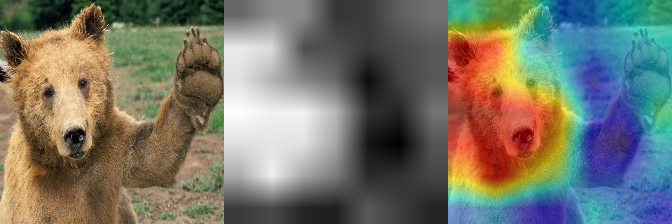

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from torchvision import models
import numpy as np
import cv2
import requests
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from PIL import Image

model = models.resnet50(pretrained=True)
model.eval()
image_url = "https://th.bing.com/th/id/R.94b33a074b9ceeb27b1c7fba0f66db74?rik=wN27mvigyFlXGg&riu=http%3a%2f%2fimages5.fanpop.com%2fimage%2fphotos%2f31400000%2fBear-Wallpaper-bears-31446777-1600-1200.jpg&ehk=oD0JPpRVTZZ6yizZtGQtnsBGK2pAap2xv3sU3A4bIMc%3d&risl=&pid=ImgRaw&r=0"
img = np.array(Image.open(requests.get(image_url, stream=True).raw))
print(type(img))
img = cv2.resize(img, (224, 224))
img = np.float32(img) / 255
input_tensor = preprocess_image(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# The target for the CAM is the Bear category.
# As usual for classication, the target is the logit output
# before softmax, for that category.
targets = [ClassifierOutputTarget(295)]
target_layers = [model.layer4]
with GradCAM(model=model, target_layers=target_layers) as cam:
    grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
    cam_image = show_cam_on_image(img, grayscale_cams[0, :], use_rgb=True)
cam = np.uint8(255*grayscale_cams[0, :])
cam = cv2.merge([cam, cam, cam])
images = np.hstack((np.uint8(255*img), cam , cam_image))
Image.fromarray(images)

In [ ]:
input_tensor.numpy().shape

(1, 3, 224, 224)

## Things to note down:

- You can change the model (any model from torchvision.models is typically fine)
- You can change the target layer (i.e. the layer which generates the predictions), but it recommended that you use the final convolutional layer
- If you do not specify the target class, then the explainer is going to select the most likely class (i.e. the class with the highest prediction confidence)

The confidence increase percent: 0.010518287308514118
The visualization of the pertubated image for the metric:


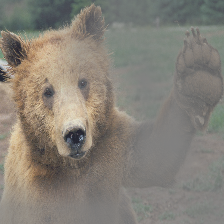

In [ ]:
# Now lets see how to evaluate this explanation:
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget

# For the metrics we want to measure the change in the confidence, after softmax, that's why
# we use ClassifierOutputSoftmaxTarget.
targets = [ClassifierOutputSoftmaxTarget(295)]
cam_metric = CamMultImageConfidenceChange()
scores, visualizations = cam_metric(input_tensor, grayscale_cams, targets, model, return_visualization=True)
score = scores[0]
visualization = visualizations[0].cpu().numpy().transpose((1, 2, 0))
visualization = deprocess_image(visualization)
print(f"The confidence increase percent: {100*score}")
print("The visualization of the pertubated image for the metric:")
Image.fromarray(visualization)

## Benchmarking CAMs

You can use the existing benchmark method in your implementation if you wish, but it is here purely as an example of how to use different CAM attribution methods

100%|██████████| 64/64 [00:04<00:00, 13.14it/s]


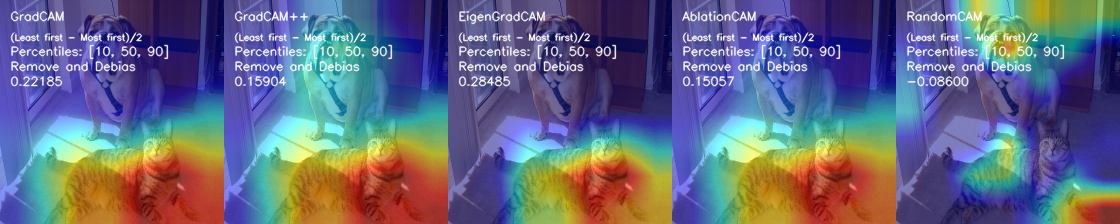

In [ ]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenGradCAM, AblationCAM, RandomCAM
from pytorch_grad_cam.metrics.road import ROADCombined

# Showing the metrics on top of the CAM :
def visualize_score(visualization, score, name, percentiles):
    visualization = cv2.putText(visualization, name, (10, 20),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "(Least first - Most first)/2", (10, 40),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"Percentiles: {percentiles}", (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, "Remove and Debias", (10, 70),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    visualization = cv2.putText(visualization, f"{score:.5f}", (10, 85),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, cv2.LINE_AA)
    return visualization

def benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False, category=281):
    methods = [("GradCAM", GradCAM(model=model, target_layers=target_layers)),
               ("GradCAM++", GradCAMPlusPlus(model=model, target_layers=target_layers)),
               ("EigenGradCAM", EigenGradCAM(model=model, target_layers=target_layers)),
               ("AblationCAM", AblationCAM(model=model, target_layers=target_layers)),
               ("RandomCAM", RandomCAM(model=model, target_layers=target_layers))]

    cam_metric = ROADCombined(percentiles=[20, 40, 60, 80])
    targets = [ClassifierOutputTarget(category)]
    metric_targets = [ClassifierOutputSoftmaxTarget(category)]

    visualizations = []
    percentiles = [10, 50, 90]
    for name, cam_method in methods:
        with cam_method:
            attributions = cam_method(input_tensor=input_tensor,
                                      targets=targets, eigen_smooth=eigen_smooth, aug_smooth=aug_smooth)
        attribution = attributions[0, :]
        scores = cam_metric(input_tensor, attributions, metric_targets, model)
        score = scores[0]
        visualization = show_cam_on_image(cat_and_dog, attribution, use_rgb=True)
        visualization = visualize_score(visualization, score, name, percentiles)
        visualizations.append(visualization)
    return Image.fromarray(np.hstack(visualizations))

cat_and_dog_image_url = "https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/both.png"
cat_and_dog = np.array(Image.open(requests.get(cat_and_dog_image_url, stream=True).raw))
cat_and_dog = np.float32(cat_and_dog) / 255
input_tensor = preprocess_image(cat_and_dog, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
target_layers = [model.layer4]

model.cuda()
input_tensor = input_tensor.cuda()

# You can play around with the target classes, target layers and random seeds to see how the cams respond
np.random.seed(42)
benchmark(input_tensor, target_layers, eigen_smooth=False, aug_smooth=False)

# target_layers = [model.layer4[-2]]
# benchmark(input_tensor, target_layers)
# benchmark(input_tensor, target_layers, category=246)

## This section shows you how to load the MedMNIST dataset

In [ ]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler
import medmnist
from medmnist import INFO

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
data_flag = 'bloodmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

train_set = DataClass(split='train', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)
test_set = DataClass(split='test', transform=data_transform, target_transform=Lambda(lambda y: y[0]), download=True)

# Define the size of the datasets
total_size = len(train_set)
train_size = int(0.7 * total_size)
valid_size = int(0.15 * total_size)
test_size = total_size - train_size - valid_size

# Split the dataset into train, validation, and test sets
train_dataset, valid_dataset, test_dataset = random_split(train_set, [train_size, valid_size, test_size])

# Define samplers for train, validation, and test sets
train_sampler = SubsetRandomSampler(range(train_size))
valid_sampler = SubsetRandomSampler(range(train_size, train_size + valid_size))
test_sampler = SubsetRandomSampler(range(train_size + valid_size, total_size))

# Define data loaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
valid_loader = DataLoader(valid_dataset, batch_size=64, sampler=valid_sampler)
test_loader = DataLoader(test_dataset, batch_size=64, sampler=test_sampler)

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the VGG16 model
model = models.vgg16(pretrained=True)

# Move the model to the device
model.to(device)


Using downloaded and verified file: /root/.medmnist/bloodmnist.npz
Using downloaded and verified file: /root/.medmnist/bloodmnist.npz


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Example on how to access and visualize the images

In [ ]:
# Assuming test_loader is an instance of DataLoader
test_iterator = iter(test_loader)

# Get the first batch (whatever the batch size is)
data_batch, target_batch = next(test_iterator)

# Access a single image and its corresponding target label from the first batch
index_of_image_to_access = 20  # You can change this index to access a different image in the batch (this case apparently >= 20)
single_image = data_batch[index_of_image_to_access]
target_label = target_batch[index_of_image_to_access]

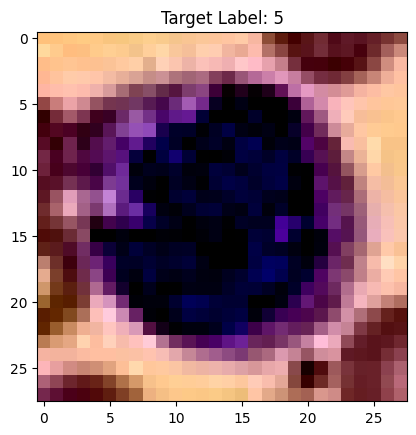

In [ ]:
import matplotlib.pyplot as plt

image_to_visualize = np.transpose(single_image.cpu().numpy(), (1, 2, 0))

# Display the image using matplotlib
plt.imshow(image_to_visualize)
plt.title(f"Target Label: {target_label.item()}")
plt.show()